<a href="https://colab.research.google.com/github/zahta/machine-learning/blob/master/hyperparameters-optimization/hyperparameter_tuning_pytorch_ray_tune_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Hyperparameter Tuning of a [PyTorch](https://pytorch.org/) Neural Network with [Ray Tune](https://docs.ray.io/en/latest/tune/index.html)

### By [Zahra Taheri](https://github.com/zahta) June 29, 2022

# Prepration of the classification dataset [Pima Indians Diabetes](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv)

## Imports

In [ ]:
#For some basic operations
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

#For visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Mount google drive to read from files and write to files

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Reading the dataset

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/opt_class/diabetes.csv')
data.shape

(768, 9)

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Descriptive statistics and data visualizations

In [ ]:
#Describe the dataset

data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
#Check the no. of unique items in each categorical column

data.select_dtypes('object').nunique()

Series([], dtype: float64)

In [ ]:
# Percentage of missing data in each column

number_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64


### Correlations

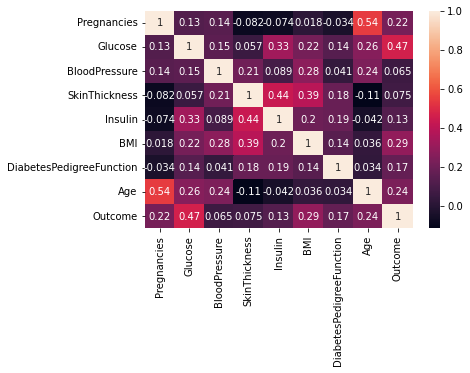

In [ ]:
sns.heatmap(data.corr(), annot = True)

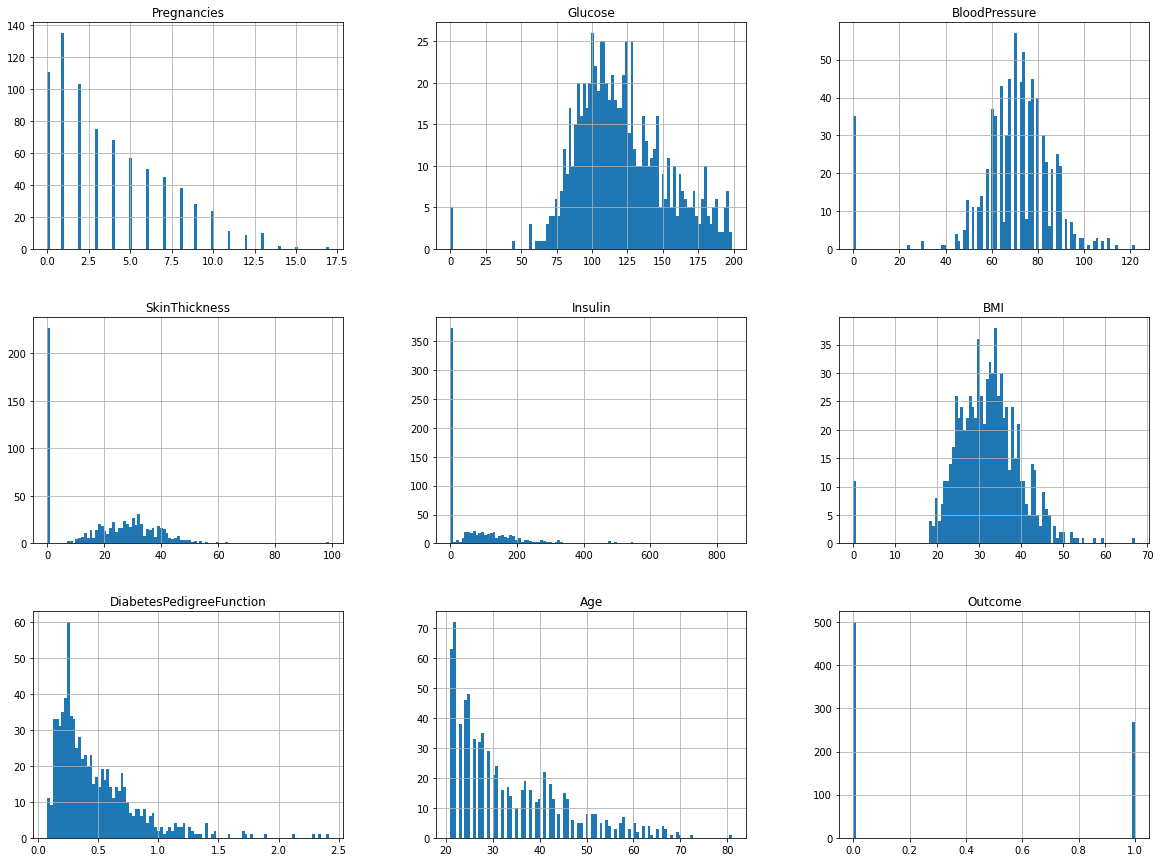

In [ ]:
data.hist(bins=100, figsize=(20,15))

plt.show()

In [ ]:
#Splitting the dependent and independent variables

X=data.iloc[:,:8].values
y=data.iloc[:,8].values
print(data.shape)
print(X.shape)
print(y.shape)

(768, 9)
(768, 8)
(768,)


In [ ]:
#Splitting the dataset into training and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(614, 8) (614,) (154, 8) (154,)


In [ ]:
type(train_labels)

numpy.ndarray

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

train_data = std_scale.fit_transform(train_data)
test_data = std_scale.transform(test_data)

train_labels = train_labels
test_labels = test_labels

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(614, 8) (614,) (154, 8) (154,)


## Preparation of the dataset for PyTorch (PyTorch dataset)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transform to torch tensor

tensor_x = torch.tensor(train_data, dtype=torch.float).to(device) 
tensor_x2 = torch.tensor(test_data, dtype=torch.float).to(device) 

tensor_y = torch.tensor(train_labels, dtype=torch.float).to(device)
tensor_y2 = torch.tensor(test_labels, dtype=torch.float).to(device)

In [ ]:
# create your dataset

trainset = TensorDataset(tensor_x, tensor_y) 
testset = TensorDataset(tensor_x2,tensor_y2)

In [ ]:
trainset[0]

(tensor([-0.5264, -1.1514, -3.7527, -1.3228, -0.7012, -4.1353, -0.4907, -1.0359]),
 tensor(0.))


# Hyperparameter optimization with Ray Tune

## Installation and imports for PyTorch models and Ray Tune

### Install Ray 

**Execute the following command for a minimal install**

`pip install -U ray `

**To install Ray with support for the dashboard + cluster launcher, run**

`pip install -U "ray[default]"`

**Most of the imports are needed for building the PyTorch model. Only the last three imports are for Ray Tune.**


In [ ]:
%%capture
try:
    import ray
except:
    !pip install -U ray
    import ray

In [ ]:
from functools import partial
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchsummary import summary

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
# Function is useful when we want to read the dataset from a file and to share a data directory 
# between different trials (specially when we are working with a large dataset).

def load_data(data_dir=None):
    return trainset, testset

## Configurable neural network




### A FNN with 3 layers without activation function

In [ ]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_dim1 = int(self.config.get("hidden_dim1",100))
        self.hidden_dim2 = int(self.config.get("hidden_dim2",100))

        self.linear1 = nn.Linear(8, self.hidden_dim1)
        self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.linear3 = nn.Linear(self.hidden_dim2, 1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        out = self.linear3(out)
        return out

In [ ]:
model = Net({})

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
summary(model, (1,tensor_x.shape[1]))

count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             900
            Linear-2               [-1, 1, 100]          10,100
            Linear-3                 [-1, 1, 1]             101
Total params: 11,101
Trainable params: 11,101
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.weight |    800     |
|  linear1.bias  |    100     |
| linear2.weight |   10000    |
|  linear2.bias  |    100     |
| linear3.weight |    100     |
|  linear3.bias  |     1      |
+----------------+------------+
Total Trainable Params: 11101


11101

### A FNN with 4 layers with some fixed activation function
https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.hidden_dim1 = int(self.config.get("hidden_dim1", 100))
        self.hidden_dim2 = int(self.config.get("hidden_dim2", 100))
        self.hidden_dim3 = int(self.config.get("hidden_dim3", 100))

        self.linear1 = nn.Linear(8, self.hidden_dim1)
        self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.linear3 = nn.Linear(self.hidden_dim2, self.hidden_dim3)
        self.linear4 = nn.Linear(self.hidden_dim3, 1)

        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        self.act3 = nn.ReLU()
        
    def forward(self, x):
        output = self.linear1(x)
        output = self.act1(output)
        output = self.linear2(output)
        output = self.act2(output)
        output = self.linear3(output)
        output = self.act3(output)
        output = self.linear4(output)        
        return output

In [ ]:
model = Net({})

In [ ]:
summary(model, (1,tensor_x.shape[1]))

count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             900
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              Tanh-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
            Linear-7                 [-1, 1, 1]             101
Total params: 21,201
Trainable params: 21,201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.09
----------------------------------------------------------------
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.we

21201

### A FNN with 4 layers and tunable fixed activation 
Note that we use this neural network for hyperparameter tuning

In [ ]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.hidden_dim1 = int(self.config.get("hidden_dim1", 100))
        self.hidden_dim2 = int(self.config.get("hidden_dim2", 100))
        self.hidden_dim3 = int(self.config.get("hidden_dim3", 100))

        self.act1 = self.config.get("act1", "relu") 
        self.act2 = self.config.get("act2", "relu") 
        self.act3 = self.config.get("act3", "relu")

        self.linear1 = nn.Linear(8, self.hidden_dim1)
        self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.linear3 = nn.Linear(self.hidden_dim2, self.hidden_dim3)
        self.linear4 = nn.Linear(self.hidden_dim3, 1)
    
    @staticmethod
    def activation_func(act_str):
        if act_str=="tanh":
            return eval("torch."+act_str)
        elif act_str=="selu" or act_str=="relu":   
            return eval("torch.nn.functional."+act_str)

    def forward(self, x):
        output = self.linear1(x)
        output = self.activation_func(self.act1)(output)
        output = self.linear2(output)
        output = self.activation_func(self.act2)(output)
        output = self.linear3(output)
        output = self.activation_func(self.act3)(output)
        output = self.linear4(output)        
        return output

In [ ]:
model = Net({})

In [ ]:
summary(model, (1,tensor_x.shape[1]))

count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             900
            Linear-2               [-1, 1, 100]          10,100
            Linear-3               [-1, 1, 100]          10,100
            Linear-4                 [-1, 1, 1]             101
Total params: 21,201
Trainable params: 21,201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.weight |    800     |
|  linear1.bias  |    100     |
| linear2.weight |   10000    |
|  linear2.bias  |    100     |
| linear3.weight |   10000    |
|  linear3.bias  |    100     |
| linear4.we

21201

## A trainable function that will be used for hyperparameter tuning of the model

- **Trainable:** Please read more about trainables from https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs
- **Optimizers:** Please read more about optimizers, e.g., [A Comprehensive Guide on Deep Learning Optimizers](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=While%20training%20the%20deep%20learning,loss%20and%20improve%20the%20accuracy.)
- **Loss functions:** Please read more about loss functions in deep learning
- **Datasets and Data loaders:**  Please read more about datasets and data loaders
    * **Some tutorials:** 

    [pytorch_datasets_tutorial_part1_csv.ipynb](https://colab.research.google.com/drive/1ZqPrIxo7RszF07gEeLMqWosWfdw0yEK-#scrollTo=-U1L7QC-bPaI)
    
    [pytorch_datasets_tutorial_part2_images.ipynb](https://colab.research.google.com/drive/1W_7lvn9Ew8bSiGkiQLXoiqtOd8In2vxx#scrollTo=yfi3EHepPzrS)

In [ ]:
def trainable_func(config, checkpoint_dir=None, data_dir=None, epochs=10):

    net = Net(config)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    '''
    Define a loss function
    '''
    ## Classification
    criterion = nn.BCEWithLogitsLoss()

    ## Regression
    # criterion = nn.MSELoss(reduction='sum')

    # Define an optimizer 
    optimizer = optim.Adam(net.parameters(), lr=config.get("lr",0.0003))

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # Load data
    trainset, testset = load_data(data_dir)

    # Split the dataset into training and validation sets
    train_size = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [train_size, len(trainset) - train_size])

    # Define data loaders (which combines a dataset and a sampler, and provides an iterable over the given dataset)
    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config.get("batch_size",8)),
        shuffle=True,
        num_workers=2)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config.get("batch_size",8)),
        shuffle=True,
        num_workers=2)

    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_train_loss = 0.0
        # epoch_steps = 0
        net.train() # Prepare model for training
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            '''
            Compute train loss without scaling to print
            ''' 
            # outputs = torch.tensor(scaler_labels.inverse_transform(outputs.detach().cpu())).to(device)    
            # labels = torch.tensor(scaler_labels.inverse_transform(labels.cpu())).to(device)  
            # loss_train = criterion(outputs, labels) 
            # epoch_train_loss += loss_train.detach().item()
        # print("[%d] loss: %.3f" % (epoch + 1, epoch_train_loss / len(train_subset)))

        # Validation score
        score = compute_score(net, valloader, device="cpu")

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
        tune.report(score=score)


## Validation and test set score

In [ ]:
from sklearn.metrics import roc_auc_score

def compute_score(model, data_loader, device="cpu"):
    model.eval()
    metric = roc_auc_score
    with torch.no_grad():
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        for i, (feats, labels) in enumerate(data_loader):
            feats=feats.to(device)
            labels=labels.to(device)
            prediction = model(feats).to(device)
            prediction = torch.sigmoid(prediction).to(device)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)                
        try:
            t = metric(labels_all.int().cpu(), prediction_all.cpu()).item()
        except ValueError:
            t = 0
    return t

## Start Ray runtime 
- Calling ray.init() (without any address args) starts a Ray runtime on your laptop/machine. This laptop/machine becomes the “head node”.
- In recent versions of Ray (>=1.5), ray.init() will automatically be called on the first use of a Ray remote API.

In [ ]:
ray.init() # Here we use ray.init() to evaluate available_resources for Ray
print(ray.available_resources())
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 

# Start Ray runtime with specific resources (not nessesarily all resources)
# You can change this values based on your machine resources)
ray.init(num_cpus=2, num_gpus=0) 

"""Check Ray Tune is working properly (for trainable class)"""
# from ray.tune.utils import validate_save_restore
# validate_save_restore(Trainable)
# validate_save_restore(Trainable, use_object_store=True)
# print("Success!")
""""""

{'CPU': 2.0, 'node:172.28.0.2': 1.0, 'object_store_memory': 3939976396.0, 'memory': 7879952795.0}


''

## Start hyperparameter tuning

In [ ]:
%%capture
try:
    import optuna
except:
    %pip install optuna
    import optuna

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):

    # define data directory here if you want to load data from files
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    # define the search space of hyperparameters
    config = {
        "act1 ": tune.choice(["relu","tanh","selu"]),
        "act2" : tune.choice(["relu","tanh","selu"]),
        "act3" : tune.choice(["relu","tanh","selu"]),
        "lr": tune.quniform(0.0005, 0.001, 0.0001),
        "batch_size": tune.choice([8, 16, 32]),
        "hidden_dim1" : tune.quniform(50, 200, 10),
        "hidden_dim2" : tune.quniform(50, 200, 10),
        "hidden_dim3" : tune.quniform(50, 200, 10),
    }

    # Optuna search algorithm
    from ray.tune.suggest.optuna import OptunaSearch 
    from ray.tune.suggest import ConcurrencyLimiter
    search_alg = OptunaSearch(
        metric="score", #or accuracy, etc.
        mode="max", #or max
        # seed = 42,
        # points_to_evaluate=[
        # {'lr': 0.0005, 'hidden_size': 150.0, 'readout1_out': 200.0, 'readout2_out': 180.0}
        # ],
        )
    search_alg = ConcurrencyLimiter(search_alg, max_concurrent=10)

    scheduler = ASHAScheduler(
        metric ="score",
        mode="max",
        max_t=max_num_epochs,
        reduction_factor=2, 
        grace_period=4,
        brackets=5
        )
    
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["score", "training_iteration"]
        )
    
    # wrap data loading and training for tuning using `partial` 
    # (note that there exist other methods for this purpose)
    result = tune.run(
        partial(trainable_func, data_dir=data_dir, epochs=max_num_epochs),
        scheduler=scheduler,
        search_alg=search_alg,
        num_samples=num_samples,
        config=config,
        verbose=2,
        checkpoint_score_attr="score",
        checkpoint_freq=0,
        keep_checkpoints_num=1,
        # checkpoint_at_end=True,
        # reuse_actors=reuse_actors_status,
        progress_reporter=reporter,
        resources_per_trial={"cpu": 0.5, "gpu": gpus_per_trial},
        stop={"training_iteration": max_num_epochs},                
        )

    best_trial = result.get_best_trial("score", "max", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation score: {}".format(
        best_trial.last_result["score"]))

    best_trained_model = Net(best_trial.config)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)
    testloader = torch.utils.data.DataLoader(
        testset, 
        batch_size=int(best_trial.config["batch_size"]), 
        shuffle=False, 
        num_workers=2)
    test_score = compute_score(best_trained_model, testloader, device)
    print("Best trial test set score: {}".format(test_score))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=50, max_num_epochs=50, gpus_per_trial=0)


2022-06-29 12:27:33,472	INFO logger.py:630 -- pip install "ray[tune]" to see TensorBoard files.
2022-06-29 12:27:33,474	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2022-06-29 12:27:34 (running for 00:00:00.84)
Memory usage on this node: 1.6/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 0.5/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-06-29_12-27-33
Number of trials: 1/50 (1 RUNNING)
+-------------------------+----------+----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+
| Trial name              | status   | loc            | act1    | act2   | act3   |   batch_size |   hidden_dim1 |   hidden_dim2 |   hidden_dim3 |     lr |
|-------------------------+----------+----------------+---------+--------+--------+--------------+---------------+----

2022-06-29 12:34:12,821	INFO tune.py:748 -- Total run time: 399.42 seconds (399.20 seconds for the tuning loop).


Trial trainable_func_aee35fee reported score=0.80584666298952,should_checkpoint=True with parameters={'act1 ': 'tanh', 'act2': 'tanh', 'act3': 'selu', 'lr': 0.0005, 'batch_size': 8, 'hidden_dim1': 80.0, 'hidden_dim2': 170.0, 'hidden_dim3': 130.0}. This trial completed.
== Status ==
Current time: 2022-06-29 12:34:12 (running for 00:06:39.22)
Memory usage on this node: 1.9/12.7 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 32.000: 0.8458204334365325 | Iter 16.000: 0.857017261122185 | Iter 8.000: 0.8519536019536018 | Iter 4.000: 0.8327904219928841
Bracket: Iter 32.000: 0.8225816054917343 | Iter 16.000: 0.84036769327467 | Iter 8.000: 0.8477857702663905
Bracket: Iter 32.000: 0.8123140987507437 | Iter 16.000: 0.8219373219373219
Bracket: Iter 32.000: 0.7984056495998115
Bracket: 
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-06-29_12-27-33
Number of trials: 50/50 (50 TERMINATED)
+------------------

## Other Schedulers and search algorithms of Ray Tune



### Installation and imports

- Install HyperOpt search algorithm for Ray Tune:
    - pip install -U hyperopt
- Install BOHB search algorithm for Ray Tune:
    - pip install hpbandster ConfigSpace

- Install Optuna search algorithm for Ray Tune:
    - pip install optuna

In [ ]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.optuna import OptunaSearch  
from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers import MedianStoppingRule
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.suggest.bohb import TuneBOHB
from ray.tune.suggest.basic_variant import BasicVariantGenerator
from ray.tune.suggest import ConcurrencyLimiter

### Schedulers
https://docs.ray.io/en/master/tune/api_docs/schedulers.html#tune-scheduler-bohb

In [ ]:
training_iteration = 50 #max_num_epochs

## ASHA
scheduler = AsyncHyperBandScheduler(
    time_attr="training_iteration",
    max_t=training_iteration,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    reduction_factor=2, 
    grace_period=4,
    brackets=5,
    )

## BOHB
scheduler = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=training_iteration, 
    reduction_factor=8, 
    stop_last_trials=True,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    )

## Median
scheduler = MedianStoppingRule(
    time_attr="training_iteration",
    grace_period=10,
    min_samples_required=10,
    hard_stop = True,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    )

## PBT
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    perturbation_interval=10,  # every 10 `time_attr` units
                            # (training_iterations in this case)
    # hyperparam_mutations={
    #     "lr": [8e-3, 7e-3, 6e-3, 5e-3, 4e-3],
    #     "dropout": tune.quniform(0.0, 0.4, 0.05),
    #     "dropout1": tune.quniform(0.0, 0.4, 0.05),
    #     "dropout2": tune.quniform(0.0, 0.4, 0.05),
    #     "max_norm_val":tune.choice([2.5, 3, 3.5, 4]),
    #     }
    )


### Search algorithms
https://docs.ray.io/en/master/tune/api_docs/suggestion.html

In [ ]:
## BOHB
search_alg = TuneBOHB(
    # space=config_space,  # If you want to set the space manually
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    # seed = 42,
    # points_to_evaluate=[
    # ],
    )

## Hyperopt
search_alg = HyperOptSearch(
    # space=config,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    n_initial_points=60,
    # gamma = 0.1,
    # random_state_seed=42,
    # points_to_evaluate=[{"max_norm_val": 2.5, 'GNN_Layers': 3, 'dropout': 0.25, 'dropout1': 0.35, 'dropout2': 0.15, 'lr': 0.001, 'hidden_size': 80, 'readout1_out': 150, 'readout2_out': 100, 'batch_size': 64}],
    )

## Optuna
search_alg = OptunaSearch(
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    # seed = 42,
    # points_to_evaluate=[
    # {'dropout': 0.2, 'dropout1': 0.1, 'dropout2': 0.25, 'lr': 0.0005, 'hidden_size': 150.0, 'readout1_out': 200.0, 'readout2_out': 180.0, 'max_norm_val': 2.5}
    # ],
    )

## Dragonfly
search_alg = DragonflySearch(
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    optimizer="bandit", #[random, bandit, genetic]
    # points_to_evaluate=[
    # {'max_norm_val': 2.5, 'dropout': 0.3, 'dropout1': 0.1, 'dropout2': 0.0, 'lr': 0.0008, 'hidden_size': 90, 'readout1_out': 150, 'readout2_out': 140}
    # ],
    # domain=euclidean, #[cartesian, euclidean]
    )

## Bayesopt
search_alg = BayesOptSearch(
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    random_search_steps = 60, 
    # points_to_evaluate=[
    # {'max_norm_val': 2.5, 'dropout': 0.3, 'dropout1': 0.1, 'dropout2': 0.0, 'lr': 0.0008, 'hidden_size': 90, 'readout1_out': 150, 'readout2_out': 140}
    # ],
    )
